In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts,StepLR, OneCycleLR
from pathlib import Path
import matplotlib.animation as animation
from sklearn.datasets import *


from utils.Models import MLP
from utils.Datasets import BBdataset
from utils.utils import *
seed = 233
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


experiment_name = "gaussian2ring"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

/home/ljb/miniconda3/envs/sde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

In [2]:
# 生成初始和目标密度样本
def gen_data(m=4, num_samples=1000, epsilon=0.001, T=1):
    mus = [(m, m), (m, -m), (-m, m), (-m, -m)]
    source_dist = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], num_samples)
    target_dist = make_circles(n_samples=num_samples, noise=0.2, factor=0.99)[0] * 6
    return source_dist, target_dist

# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = 1
    bridge = torch.zeros((ts.shape[0], num_samples, 2))
    drift = torch.zeros((ts.shape[0], num_samples, 2))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

# 主函数
def gen_2d_data(m=4, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    source_dist, target_dist = gen_data(m, num_samples, epsilon, T)
    ts = torch.arange(0, T+epsilon, epsilon)
    source_dist = torch.Tensor(source_dist)
    target_dist = torch.Tensor(target_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, ts, T=T, num_samples=num_samples)
    return ts, bridge, drift, source_dist, target_dist

ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=1000)

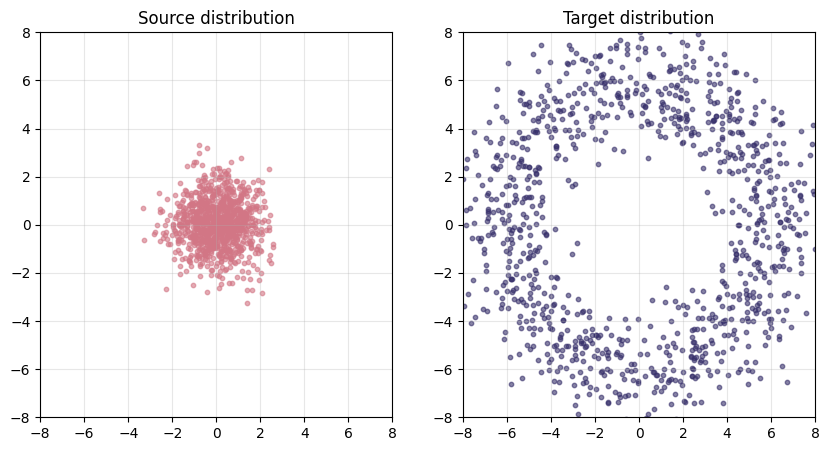

In [3]:
def plot_source_and_target(sour, targ, left_title="Source distribution", right_title="Target distribution", save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(*sour.T, c='#D27685', s=10, alpha=0.6)
    axs[1].scatter(*targ.T, c='#37306B', s=10, alpha=0.6)
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    axs[0].grid(True, alpha=0.3)
    axs[1].grid(True, alpha=0.3)
    axs[0].set_xlim(-8, 8)
    axs[0].set_ylim(-8, 8)
    axs[1].set_xlim(-8, 8)
    axs[1].set_ylim(-8, 8)
    fig.show()
    if save_path is not None:
        fig.savefig(save_path)

plot_source_and_target(source_sample, target_sample)

In [4]:
def draw_gaussian2d(bridge, colors=True):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3

    # 生成数据
    color_list = ['#37306B', '#66347F', '#9E4784', '#D27685']  # 对应于目标均值的颜色

    # 创建3D图形
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 为每个样本绘制bridge
    for i in range(bridge.shape[1]):
        x = bridge[:, i, 0].numpy()  # X坐标
        y = bridge[:, i, 1].numpy()  # Y坐标
        z = ts.numpy()               # 时间作为Z坐标
        c = color_list[get_color((x[-1], y[-1]))] if colors else '#D27685'
        ax.plot(x, y, z, color=c, label=f'Sample {i+1}', alpha=0.3)

    # 添加标签和图例
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')

    fig.show()

In [5]:
def draw_gaussian2d_gif(bridge):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3
    colors = ['b', 'g', 'r', 'c']  # 对应于目标均值的颜色
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # 定义更新函数
    def update(frame):
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        for i in range(bridge.shape[1]):
            x = bridge[:frame + 1, i, 0].numpy()  # 注意：frame + 1
            y = bridge[:frame + 1, i, 1].numpy()  # 注意：frame + 1
            if x.size > 0 and y.size > 0:  # 确保x和y不为空
                color_index = get_color((x[-1], y[-1]))
                ax.plot(x, y, color=colors[color_index], alpha=0.5)
                ax.scatter(x[-1], y[-1], color=colors[color_index], alpha=1, s=10)
    # 创建动画
    ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=100)
    # 保存为GIF需要花费6分钟左右
    ani.save(log_dir / 'brownian_bridge.gif', writer='imagemagick')

In [6]:
num_samples = 4000
ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=num_samples)
print_debug(ts, bridge, drift, source_sample, target_sample)
start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1, 1), 1, dim=1), dim=0)
times = ts[:len(ts)-1].repeat(num_samples, 1).reshape(-1, 1, 1)
positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)
print_debug(start, times, positions, scores)
raw_data = torch.concat([start, times, positions, scores], dim=-1)
raw_data.shape

====================

torch.Size([1001])
torch.float32 cpu

torch.Size([1001, 4000, 2])
torch.float32 cpu

torch.Size([1001, 4000, 2])
torch.float32 cpu

torch.Size([4000, 2])
torch.float32 cpu

torch.Size([4000, 2])
torch.float32 cpu

====================

torch.Size([4000000, 1, 2])
torch.float32 cpu

torch.Size([4000000, 1, 1])
torch.float32 cpu

torch.Size([4000000, 1, 2])
torch.float32 cpu

torch.Size([4000000, 1, 2])
torch.float32 cpu

torch.Size([4000000, 1, 7])

In [7]:
epochs = 20
batch_size = 1000
lr = 1e-4

# 组合成data
train_ds = BBdataset(raw_data)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = MLP(input_dim=5, output_dim=2, hidden_layers=4, hidden_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_list = []
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data.to(device)
        # x: (batch_size, channel, length-2), y: (batch_size, channel, 2)
        x, y = training_data[:, :, :-2], training_data[:, :, -2:] # 不同模型要改
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, None, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
test_num_samples = 4000
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_2d_data(num_samples=test_num_samples)
# print_debug(test_ts, test_bridge, test_drift, test_source_sample, test_target_sample)
pred_bridge = torch.zeros_like(test_bridge)
pred_bridge[0, :] = test_source_sample
model.eval()
model.cpu()
sigma=1
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1, test_source_sample.shape[-1])
        test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, pred_bridge.shape[-1])
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=-1)
        dydt = model(x)
        # print_debug(dydt)
        dydt = dydt[:, 0, :]
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, 2)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion
        
        
        
        # dt = ts[i+1] - ts[i]
        # dydt = (y - bridge[i]) / (T - ts[i])
        # drift[i, :] = dydt
        # diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        # bridge[i+1] = bridge[i] + dydt * dt + diffusion

In [43]:
# draw_gaussian2d(bridge, False)

In [44]:
# draw_gaussian2d(pred_bridge, False)

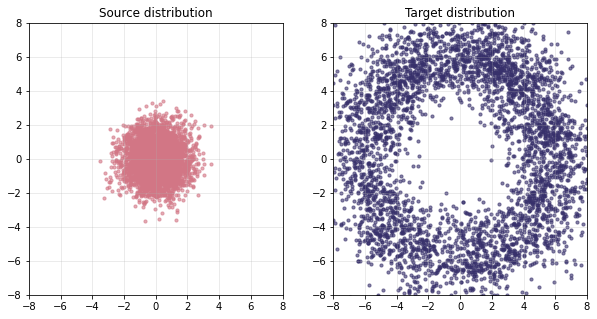

In [68]:
plot_source_and_target(pred_bridge[0, :, :], pred_bridge[-1, :, :], save_path=log_dir / 'pred_bridge.jpg')

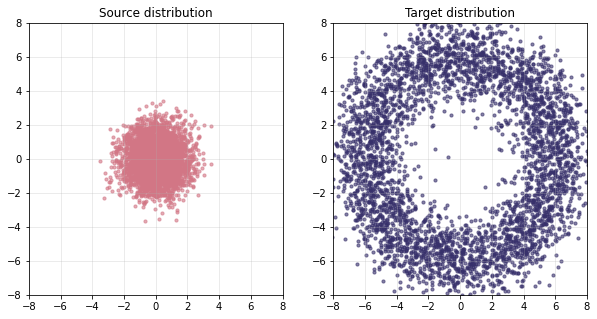

In [69]:
plot_source_and_target(test_bridge[0, :, :], test_bridge[-1, :, :], save_path=log_dir / 'gt_test_bridge.jpg')

In [24]:
# torch.save(pred_bridge, 'pred_bridge.pt')